# Run simulation 

In [1]:
import numpy as np
import pandas as pd
from utils.array_to_df import using_multiindex

# Parameters
G = 5  # Number of generations
N_gen = 8  # Number of agents per generation
N_mach = 3  # Number of machines
P_ind = 2  # Number of problems for individual learning
P_soc = 4  # Number of problems for social learning
P_tot = P_ind + 2*P_soc  # Total number of problems
R_myopic = 1400  # Base reward for myopic solution
R_optimal = 2200  # Base reward for optimal solution
R_random = 600  # Base reward for random solutions
sigma = 200  # Standard deviation for Gaussian noise
d_myopic = 0.4  # Discoverability rate for myopic solutions
# d_optimal = 0.0001  # Discoverability rate for optimal solutions
# l_myopic = 0.11 # Learnability (probability of imitating the myopic solution)
# l_optimal = 0.11  # Learnability (probability of imitating the optimal solution)
machine_discovery_factor = 3  # Factor for the discovery rate of machines (order of magnitude)
epsilon = 0.5 # Probability of random exploration
# K = 5  # Number of agents observed during social learning
M_ = 100  # Number of replications of the simulation
n_teacher_ = [1, 5] # Number of agents observed during social learning

d_optimal_log_ = np.linspace(0, -6, 25)
d_optimal_ = np.power(10, d_optimal_log_)

l_optimal_ = np.linspace(0.0, 0.35, 36)
conditions_ = ['human', 'human-machine']

conditions = []
n_teacher = []

l_optimal = []
d_optimal_log = []
d_optimal = []
for n_t in n_teacher_:
    for c in conditions_:
        for d, d_log in zip(d_optimal_, d_optimal_log_):
            for l in l_optimal_:
                for m in range(M_):
                    conditions.append(c)
                    d_optimal.append(d)
                    l_optimal.append(l)
                    d_optimal_log.append(d_log)
                    n_teacher.append(n_t)

conditions = np.array(conditions)
d_optimal_ = np.array(d_optimal)
l_optimal = np.array(l_optimal)
d_optimal_log = np.array(d_optimal_log)
d_myopic = np.ones_like(d_optimal) * d_myopic
l_myopic = l_optimal

M = len(conditions)

d_optimal = np.tile(d_optimal, (G, N_gen, 1)).transpose((2, 0, 1))

In [2]:
# Initialize agent preferences and exploration parameters
agent_prefs = np.ones((M, G, N_gen, P_tot), dtype=int) * -1 # 0: myopic, 1: optimal

is_machine = np.zeros((M, G, N_gen), dtype=bool)
is_machine[conditions == 'human-machine',0,:N_mach] = True

d_optimal[is_machine] = d_optimal[is_machine] * 10**machine_discovery_factor

# set machine preferences
# agent_prefs[conditions == 'human-machine', 0, :N_mach, :] = 1
solution_types = np.zeros((M, G, N_gen, P_tot), dtype=int)  # -1: random, 0: myopic, 1: optimal
rewards = np.zeros((M, G, N_gen, P_tot))
demo_solution_types = np.zeros((M, G, N_gen, P_tot), dtype=int)


def get_reward(solution_type):
    # Determine the base reward for each solution type
    is_myopic = solution_type == 0
    is_optimal = solution_type == 1
    base_reward = np.where(is_myopic, R_myopic, np.where(is_optimal, R_optimal, R_random))
    # Add Gaussian noise to the base reward
    noise = np.random.normal(0, sigma, size=base_reward.shape)
    return base_reward + noise

def solve_problem(agent_pref, d_myopic, d_optimal, allow_exploration=True):
    if allow_exploration:
        # Determine whether each agent explores or exploits
        explore = (np.random.rand(M, N_gen) < epsilon) & (agent_pref != 1)

        # Randomly discover the optimal solution during exploration
        discovered_myopic = (np.random.rand(M, N_gen) < d_myopic) & explore
        discovered_optimal = (np.random.rand(M, N_gen) < d_optimal) & explore
        random_solution = explore & (discovered_myopic | discovered_optimal)

        # Update agent preferences when discovered optimal solution
        agent_pref = np.where(discovered_myopic, 0, agent_pref)
        agent_pref = np.where(discovered_optimal, 1, agent_pref)

    solution_types = agent_pref.copy()

    if allow_exploration:
        # Update solution types for random exploration
        solution_types[random_solution] = -1

    rewards = get_reward(solution_types)
    return agent_pref, solution_types, rewards


def get_demo_solution_types(prev_rewards, prev_solution_types, n_teacher):
    avg_prev_reward = prev_rewards[:,:,-P_soc:].mean(axis=2) # Average reward for each agent over the last P_soc problems
    demo_solution_types = np.zeros((M, N_gen, P_tot), dtype=int) # Solution types passed from teachers to students
    for m in range(prev_rewards.shape[0]): # For each replication
        for n in range(prev_rewards.shape[1]): # For each agent
            random_k_possible_teacher = np.random.choice(N_gen, n_teacher[m], replace=False) # Randomly select K possible teachers
            teacher_indices = np.argmax(avg_prev_reward[m, random_k_possible_teacher]) # Select the teacher with the highest average reward
            teacher_indices = random_k_possible_teacher[teacher_indices] # Retrieve the teacher's index
            demo_solution_types[m, n] = prev_solution_types[m, teacher_indices] # Pass the teacher's solution types to the student
    return demo_solution_types


def social_learning(agent_pref, demo_solution_type):
    learned_optimal = (np.random.rand(M, N_gen) < l_optimal[:,np.newaxis]) & (demo_solution_type == 1)
    learned_myopic = (np.random.rand(M, N_gen) < l_myopic[:,np.newaxis]) & (demo_solution_type == 0)

    # Update agent preferences when discovered optimal solution
    agent_pref = np.where(learned_myopic & (agent_pref != 1), 0, agent_pref)
    agent_pref = np.where(learned_optimal, 1, agent_pref)

    return agent_pref


for g in range(G):
    if g > 0:
        demo_solution_types[:,g] = get_demo_solution_types(rewards[:,g-1], solution_types[:,g-1], n_teacher)
    for p in range(P_tot):
        is_individual_learning = (g > 0 and p < P_ind) or (g == 0 and p < P_ind + P_soc)
        is_social_learning = g > 0 and p >= P_ind and p < P_ind + P_soc
        is_demo = p >= P_ind + P_soc
        if is_social_learning:
            agent_prefs[:,g,:,p] = social_learning(agent_prefs[:,g,:,p], demo_solution_types[:,g,:,p+4])
        agent_prefs[:,g,:,p], solution_types[:,g,:,p], rewards[:,g,:,p] = solve_problem(
            agent_prefs[:,g,:,p], d_myopic[:,np.newaxis], d_optimal[:,g], allow_exploration=not is_demo)
        if p < P_tot - 1:
            agent_prefs[:, g, :, p + 1] = agent_prefs[:, g, :, p]


In [3]:
rewards_df = using_multiindex(rewards, ['rep', 'gen', 'agent', 'problem'])
agent_prefs_df = using_multiindex(agent_prefs, ['rep', 'gen', 'agent', 'problem'])
solution_types_df = using_multiindex(solution_types, ['rep', 'gen', 'agent', 'problem'])
demo_solution_types_df = using_multiindex(demo_solution_types, ['rep', 'gen', 'agent', 'problem'])

problem_types = {"individual": list(range(P_ind)), "social": list(range(P_ind, P_ind + P_soc)), "demo": list(range(P_ind + P_soc, P_tot))}
problem_types_map = {p_id: p_name for p_name, p_ids in problem_types.items() for p_id in p_ids}

rep_map = pd.DataFrame({
    'rep': np.arange(M),
    'condition': conditions,
    'd_optimal': d_optimal_,
    'l_optimal': l_optimal,
    'd_optimal_log': d_optimal_log,
    'd_myopic': d_myopic,
    'l_myopic': l_myopic,
    'n_teacher': n_teacher
})


rewards_df['problem_type'] = rewards_df['problem'].map(problem_types_map)
agent_prefs_df['problem_type'] = agent_prefs_df['problem'].map(problem_types_map)
solution_types_df['problem_type'] = solution_types_df['problem'].map(problem_types_map)
demo_solution_types_df['problem_type'] = demo_solution_types_df['problem'].map(problem_types_map)

rewards_df = rewards_df.merge(rep_map, on='rep')
agent_prefs_df = agent_prefs_df.merge(rep_map, on='rep')
solution_types_df = solution_types_df.merge(rep_map, on='rep')
demo_solution_types_df = demo_solution_types_df.merge(rep_map, on='rep')

rewards_df['is_machine'] = (rewards_df['condition'] == 'human-machine') & (rewards_df['agent'] <= N_mach) & (rewards_df['gen'] == 0)
agent_prefs_df['is_machine'] = (agent_prefs_df['condition'] == 'human-machine') & (agent_prefs_df['agent'] <= N_mach) & (agent_prefs_df['gen'] == 0)
solution_types_df['is_machine'] = (solution_types_df['condition'] == 'human-machine') & (solution_types_df['agent'] <= N_mach) & (solution_types_df['gen'] == 0)
demo_solution_types_df['is_machine'] = (demo_solution_types_df['condition'] == 'human-machine') & (demo_solution_types_df['agent'] <= N_mach) & (demo_solution_types_df['gen'] == 0)

rewards_df.to_parquet('../data/abm/rewards.parquet')
agent_prefs_df.to_parquet('../data/abm/agent_prefs.parquet')
solution_types_df.to_parquet('../data/abm/solution_types.parquet')
demo_solution_types_df.to_parquet('../data/abm/demo_solution_types.parquet')

# Analysis

In [4]:
rewards_df = pd.read_parquet('../data/abm/rewards.parquet')
agent_prefs_df = pd.read_parquet('../data/abm/agent_prefs.parquet')
solution_types_df = pd.read_parquet('../data/abm/solution_types.parquet')
demo_solution_types_df = pd.read_parquet('../data/abm/demo_solution_types.parquet')

In [5]:
last_gen = rewards_df['gen'] == G - 1
demo = rewards_df['problem_type'] == 'demo'

df = rewards_df[last_gen & demo]

reward_matrix = df.pivot_table(index=['condition', 'n_teacher', 'l_optimal'], columns='d_optimal_log', values='value')
reward_diff_matrix = reward_matrix.loc['human-machine'] - reward_matrix.loc['human']


first_gen = rewards_df['gen'] == 0
demo = rewards_df['problem_type'] == 'demo'
is_machine = rewards_df['is_machine']
is_hybrid = rewards_df['condition'] == 'human-machine'

df = rewards_df[first_gen & demo & is_machine & is_hybrid]

machine_reward_matrix = df.pivot_table(index=['n_teacher', 'l_optimal'], columns='d_optimal_log', values='value')


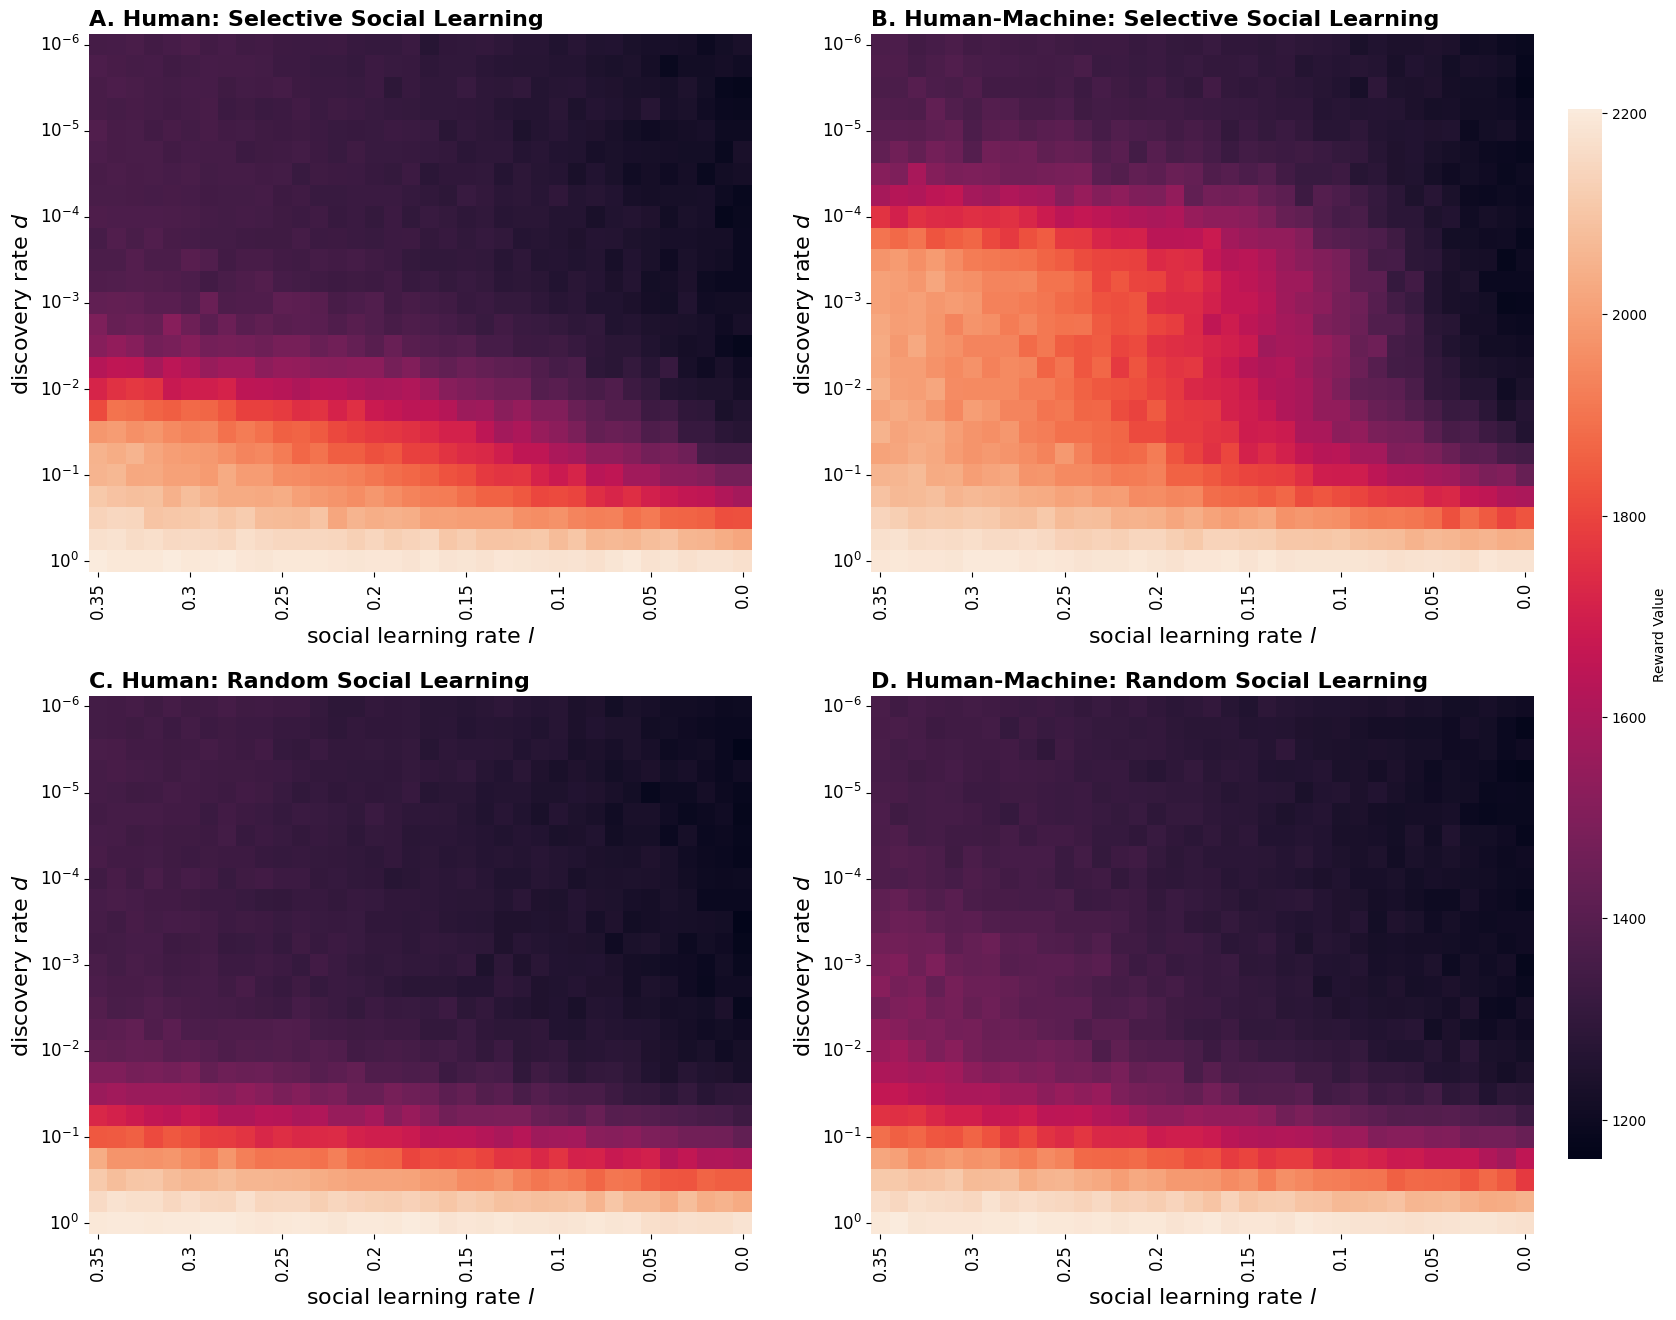

In [7]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Create a figure
fig = plt.figure(figsize=(17, 15))
gs = GridSpec(2, 2, width_ratios=[1, 1])

# Create subplots using the GridSpec
axes = [fig.add_subplot(gs[i, j]) for i in [0, 1] for j in [0, 1]]

# Extract data for the heatmaps
m1 = reward_matrix.loc['human', 5].iloc[::-1].T # human population with best teacher of 5
m2 = reward_matrix.loc['human-machine', 5].iloc[::-1].T # human-machine population with best teacher of 5
m3 = reward_matrix.loc['human', 1].iloc[::-1].T # human population with best teacher of 1
m4 = reward_matrix.loc['human-machine', 1].iloc[::-1].T # human-machine population with best teacher of 1

# Find the global min and max for consistent color scaling
vmin = min(m1.min().min(), m2.min().min(), m3.min().min(), m4.min().min())
vmax = max(m1.max().max(), m2.max().max(), m3.max().max(), m4.max().max())

# Plot the heatmaps with consistent color scaling
heatmaps = [
    sns.heatmap(m1, ax=axes[0], cbar=False, vmin=vmin, vmax=vmax),
    sns.heatmap(m2, ax=axes[1], cbar=False, vmin=vmin, vmax=vmax),
    sns.heatmap(m3, ax=axes[2], cbar=False, vmin=vmin, vmax=vmax),
    sns.heatmap(m4, ax=axes[3], cbar=False, vmin=vmin, vmax=vmax),
]

# Add a single color bar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = fig.colorbar(heatmaps[0].collections[0], cax=cbar_ax, label='Reward Value')

# Remove the border around the color bar
cbar.outline.set_visible(False)

# Set x and y tick labels
for i, ax in enumerate(axes):
    x_ticks = [(i + 0.5, f"{x:.2}") for i, x in enumerate(m1.columns) if i % 5 == 0]
    ax.set_xticks([t[0] for t in x_ticks])
    ax.set_xticklabels([t[1] for t in x_ticks], size=12)

    ax.set_ylabel('discovery rate $d$', size=16)
    y_ticks = [(i + 0.5, f"$10^{{{int(x):.0f}}}$") for i, x in enumerate(m1.index) if int(x) == x]
    ax.set_yticks([t[0] for t in y_ticks])
    ax.set_yticklabels([t[1] for t in y_ticks], size=12)
    ax.set_xlabel('social learning rate $l$', size=16)

# Set titles for each subplot
axes[0].set_title('A. Human: Selective Social Learning', loc='left', size=16, weight='bold')
axes[1].set_title('B. Human-Machine: Selective Social Learning', loc='left', size=16, weight='bold')
axes[2].set_title('C. Human: Random Social Learning', loc='left', size=16, weight='bold')
axes[3].set_title('D. Human-Machine: Random Social Learning', loc='left', size=16, weight='bold')


# Adjust spacing between plots
plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.18, hspace=0.23)

# Save the figure
plt.savefig('plots/abm/heatmap_details.png', dpi=300, bbox_inches='tight')
plt.savefig('plots/abm/heatmap_details.pdf', dpi=300, bbox_inches='tight')


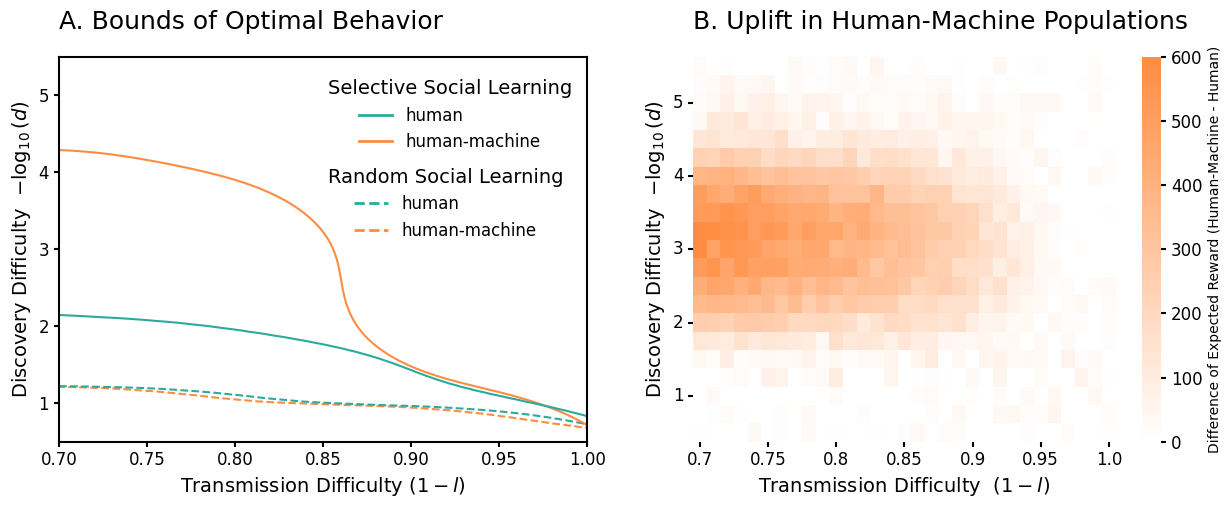

In [8]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Custom configuration dictionary with explicit settings
config = {
    'legend.fontsize': 12,
    'legend.titlesize': 14,
    'legend.labelsize': 10,
    'axes.labelsize': 14,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.titlesize': 16,
    'figure.figsize': (15, 5),
    'xlim': (0.70, 1),
    'ylim': (0.5, 5.5),
    'heatmap.cbar': True,
    'heatmap.cmap': 'Greys',
    'dpi': 300,
    'line.width': 1.5
}

# Apply configurations
plt.rcParams.update({
    'legend.fontsize': config['legend.fontsize'],
    'axes.labelsize': config['axes.labelsize'],
    'axes.titlesize': config['axes.titlesize'],
    'xtick.labelsize': config['xtick.labelsize'],
    'ytick.labelsize': config['ytick.labelsize'],
    'figure.titlesize': config['figure.titlesize'],
})


custom_palette = {
    'human-machine': '#FF8C41',
    'human': '#2BAA9D'
}

# Create a figure with the specified figsize from config
fig = plt.figure(figsize=config['figure.figsize'])

# Define GridSpec layout for subplots
gs = GridSpec(1, 2, width_ratios=[1.0, 1.0])

# Create subplots using GridSpec
axes = [fig.add_subplot(gs[i]) for i in [0, 1]]

# Panel A
ax = axes[0]

# Data preparation for Panel A
last_gen = solution_types_df['gen'] == G - 1
demo = solution_types_df['problem_type'] == 'demo'
df = solution_types_df[last_gen & demo].copy()
df['optimal_rate'] = (df['value'] == 1)

# Pivot and reformat data
m1 = df.pivot_table(index=['condition', 'n_teacher', 'l_optimal'], columns='d_optimal_log', values='optimal_rate')
df = m1.stack().reset_index()
df.columns = ['type', 'n_teacher', 'l_optimal', 'd_optimal_log', 'optimal_rate']
df['learnability difficulty'] = 1 - df['l_optimal']
df['discoverability difficulty'] = -df['d_optimal_log']
df['weight'] = (df['optimal_rate'] > 0.5)

# Plot KDE for n_teacher == 1 and n_teacher == 5
for n_teacher, linestyle in zip([1, 5], ["--", "-"]):
    sns.kdeplot(
        data=df[df['n_teacher'] == n_teacher], weights='weight',
        x='learnability difficulty', y='discoverability difficulty',
        fill=False, levels=2, hue='type', bw_adjust=1,
        hue_order=['human-machine', 'human'], linestyles=linestyle,
        ax=ax, palette=custom_palette
    )

# Set limits from config
ax.set_xlim(*config['xlim'])
ax.set_ylim(*config['ylim'])

# Define custom legend lines and add legends
custom_lines_selective = [
    Line2D([0], [0], color=custom_palette['human'], linestyle="-", lw=2, label='human'),
    Line2D([0], [0], color=custom_palette['human-machine'], linestyle="-", lw=2, label='human-machine'),
]
legend1 = ax.legend(
    handles=custom_lines_selective, loc='upper left', bbox_to_anchor=(0.48, 0.98),
    title='Selective Social Learning', fontsize=config['legend.fontsize'], frameon=False, title_fontsize=config['legend.titlesize']
)
ax.add_artist(legend1)

custom_lines_random = [
    Line2D([0], [0], color=custom_palette['human'], linestyle="--", lw=2, label='human'),
    Line2D([0], [0], color=custom_palette['human-machine'], linestyle="--", lw=2, label='human-machine'),
]
legend2 = ax.legend(
    handles=custom_lines_random, loc='upper left', bbox_to_anchor=(0.48, 0.75),
    title='Random Social Learning', fontsize=config['legend.fontsize'], frameon=False, title_fontsize=config['legend.titlesize']
)

# Set labels and title
ax.set_ylabel('Discovery Difficulty  $-\\log_{10}(d)$')
ax.set_xlabel('Transmission Difficulty $(1 - l)$')
ax.set_title('A. Bounds of Optimal Behavior', loc='left', pad=20)

# Increase spine line width for each subplot
for spine in ax.spines.values():
    spine.set_linewidth(config['line.width'])

# Increase tick width
ax.tick_params(axis='both', width=config['line.width'])

# Panel B
ax = axes[1]

# Data preparation for Panel B
last_gen = rewards_df['gen'] == G - 1
demo = rewards_df['problem_type'] == 'demo'
df = rewards_df[last_gen & demo].copy()
df['learnability difficulty'] = 1 - df['l_optimal']
df['discoverability difficulty'] = -df['d_optimal_log']


# trim df based on limits
df = df[(df['learnability difficulty'] >= config['xlim'][0]) & (df['learnability difficulty'] <= config['xlim'][1])]
df = df[(df['discoverability difficulty'] >= config['ylim'][0]) & (df['discoverability difficulty'] <= config['ylim'][1])]

reward_matrix = df.pivot_table(index=['condition', 'n_teacher', 'learnability difficulty'],
                               columns='discoverability difficulty', values='value')
reward_diff_matrix = reward_matrix.loc['human-machine', 5] - reward_matrix.loc['human', 5]
m3 = reward_diff_matrix.T.iloc[::-1]

# Plot heatmap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#FFFFFF", custom_palette['human-machine']])

hm = sns.heatmap(m3, ax=ax, cbar=True, cmap=custom_cmap, vmin=0, vmax=600)

cbar = hm.collections[0].colorbar
cbar.ax.tick_params(width=config['line.width'])
cbar.set_label('Difference of Expected Reward (Human-Machine - Human)', fontsize=config['legend.labelsize'])


# Set ticks based on specific x and y values for better readability
x_ticks = [(i+0.5, f"{x:.2}") for i, x in enumerate(m3.columns) if int(x * 20) == x * 20]
ax.set_xticks([t[0] for t in x_ticks])
ax.set_xticklabels([t[1] for t in x_ticks], fontsize=config['xtick.labelsize'], rotation=0)

y_ticks = [(i+0.5, f"{int(x)}") for i, x in enumerate(m3.index) if int(x) == x]
ax.set_yticks([t[0] for t in y_ticks])
ax.set_yticklabels([t[1] for t in y_ticks], fontsize=config['ytick.labelsize'], rotation=0)

# Set labels and title for Panel B
ax.set_ylabel('Discovery Difficulty  $-\\log_{10}(d)$')
ax.set_xlabel('Transmission Difficulty  $(1 - l)$')
ax.set_title('B. Uplift in Human-Machine Populations', loc='left', pad=20)

# Increase spine line width for each subplot
for spine in ax.spines.values():
    spine.set_linewidth(config['line.width'])

# Increase tick width
ax.tick_params(axis='both', width=config['line.width'])

# Save the figure with dpi from config
plt.savefig('plots/abm/heatmap.png', bbox_inches='tight', dpi=config['dpi'])
plt.savefig('plots/abm/heatmap.pdf', bbox_inches='tight', dpi=config['dpi'])